# 네이버 영화평 감성분석 -LSTM

In [1]:
!pip install konlpy > /dev/null

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 네이버 영화 리뷰 데이터로 검색
train_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', sep='\t')
test_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', sep='\t')

In [4]:
print(train_df.shape, test_df.shape)
train_df.head(3)

(150000, 3) (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


## 1.데이터 전처리
- 트레인 데이터셋

In [5]:
# Null 데이터 제거
train_df.dropna(how='any', inplace=True) 
# 중복 데이터 제거
train_df.drop_duplicates(subset=['document'], inplace=True) 
train_df.shape

(146182, 3)

- 테스트 데이터셋

In [6]:
test_df.dropna(how='any', inplace=True)
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape


(49157, 3)

## 2.텍스트 전처리
- 트레인 데이터셋

In [7]:
# 한글 이외의 문자는 공백으로 처리하고 strip
train_df.document = train_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
# '' 만 남은 데이터 --> np.nan 으로 대체한 후 제거
train_df.document.replace('', np.nan, inplace=True)
train_df.document.isna().sum()

789

In [8]:
train_df.dropna(how='any', inplace=True)
train_df.shape

(145393, 3)

- 테스트 데이터셋

In [9]:
test_df.document = test_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
test_df.document.replace('', np.nan, inplace=True)
test_df.dropna(how='any', inplace=True)
test_df.shape

(48852, 3)

## 3.한글 처리


In [10]:
from konlpy.tag import Okt
okt = Okt()

In [11]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']


In [12]:
from tqdm.notebook import tqdm

X_train = []
for sentence in tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_X = [word for word in morphs if word not in stopwords]
    #케라스 토크나이저는 문장으로 안 주고 숫자로 주기 때문에 ' '.join 안 해줘도 됨.
    X_train.append(tmp_X)

  0%|          | 0/145393 [00:00<?, ?it/s]

In [13]:
from tqdm import tqdm
X_test = []
for sentence in tqdm(test_df.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_str = ' '.join([word for word in morphs if word not in stopwords])
    X_test.append(tmp_str)

100%|██████████| 48852/48852 [02:24<00:00, 338.32it/s]


In [14]:
y_train = train_df.label.values 
y_test = test_df.label.values

## 4.케라스 토크나이저 - train/test dataset

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
t=Tokenizer()
t.fit_on_texts(X_train)

In [16]:
len(t.word_index)

43118

In [17]:
#빈도수 상위 2만 개 단어로 인코딩
num_words=20000
t=Tokenizer(num_words=num_words)
t.fit_on_texts(X_train)

In [18]:
#x test 안 하고 xtrain을 분할시킨 것. 너무 시간 걸려서
#from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test = train_test_split(
#    X_train, train_df.label.values, stratify=train_df.label.values,
#    test_size=0.2,random_state=seed
#)

In [19]:
#데이터의 분포(최대 길이/평균 길이) 알아보기
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)


In [20]:
max(len(s) for s in X_train),sum(map(len, X_train))/len(X_train)


(70, 10.610139415240074)

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len=40
X_train=pad_sequences(X_train, maxlen=max_len)
X_test=pad_sequences(X_test, maxlen=max_len)
X_train.shape,X_test.shape

((145393, 40), (48852, 40))

## 5.LSTM 모델 정의/설정/학습

In [22]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [23]:
model=Sequential([
                  Embedding(num_words, 120, input_length=max_len),
                  LSTM(128),
                  Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 120)           2400000   
                                                                 
 lstm (LSTM)                 (None, 128)               127488    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,527,617
Trainable params: 2,527,617
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile('adam','binary_crossentropy',['accuracy'])

In [25]:
model_path='best-navermovie-lstm.h5'
mc=ModelCheckpoint(model_path,verbose=1,save_best_only=True)
es=EarlyStopping(patience=5)

In [26]:
hist=model.fit(
    X_train,y_train,validation_split=0.2,
    epochs=30,batch_size=128,callbacks=[mc,es]
)

Epoch 1/30
909/909 [==============================] - ETA: 0s - loss: 0.3921 - accuracy: 0.8211
Epoch 1: val_loss improved from inf to 0.35666, saving model to best-navermovie-lstm.h5
909/909 [==============================] - 15s 8ms/step - loss: 0.3921 - accuracy: 0.8211 - val_loss: 0.3567 - val_accuracy: 0.8435
Epoch 2/30
909/909 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.8701
Epoch 2: val_loss improved from 0.35666 to 0.34423, saving model to best-navermovie-lstm.h5
909/909 [==============================] - 7s 8ms/step - loss: 0.3039 - accuracy: 0.8701 - val_loss: 0.3442 - val_accuracy: 0.8523
Epoch 3/30
909/909 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.8932
Epoch 3: val_loss did not improve from 0.34423
909/909 [==============================] - 6s 7ms/step - loss: 0.2543 - accuracy: 0.8932 - val_loss: 0.3553 - val_accuracy: 0.8507
Epoch 4/30
902/909 [============================>.] - ETA: 0s - loss: 0.2142 - accuracy: 0.

In [27]:
best_model=load_model(model_path)
best_model.evaluate(X_test,y_test)

1527/1527 [==============================] - 5s 3ms/step - loss: 0.3497 - accuracy: 0.8474


[0.3497067987918854, 0.847375750541687]

## 6.실제 데이터 예측

In [31]:
review='꿀잼'

In [39]:
import re

review=re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',review).strip()

In [40]:
morphs = okt.morphs(review, stem=True)
morphs = [word for word in morphs if word not in stopwords]
encoded=t.texts_to_sequences([morphs])
padded=pad_sequences(encoded,maxlen=max_len)
score=float(best_model.predict(padded))
print('긍정' if score > 0.5 else '부정')

긍정


In [45]:
def sentiment_predict(review,tokenizer=t,max_len=max_len):
    review=re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',review).strip()
    morphs = okt.morphs(review, stem=True)
    morphs = [word for word in morphs if word not in stopwords]
    encoded=t.texts_to_sequences([morphs])
    padded=pad_sequences(encoded,maxlen=max_len)
    score=float(best_model.predict(padded))
    return f'긍정({score*100:.2f}%)' if score > 0.5 else f'부정({(1-score)*100:.2f}%)'

In [46]:
sentiment_predict('잼있음')

'긍정(95.50%)'

In [47]:
sentiment_predict('개노잼')

'부정(99.50%)'

## 7.학습과정 시각화

In [49]:
y_acc=hist.history['accuracy']
y_loss=hist.history['loss']
y_vacc=hist.history['val_accuracy']
y_vloss=hist.history['val_loss']

xs=np.arange(1,len(y_acc)+1)

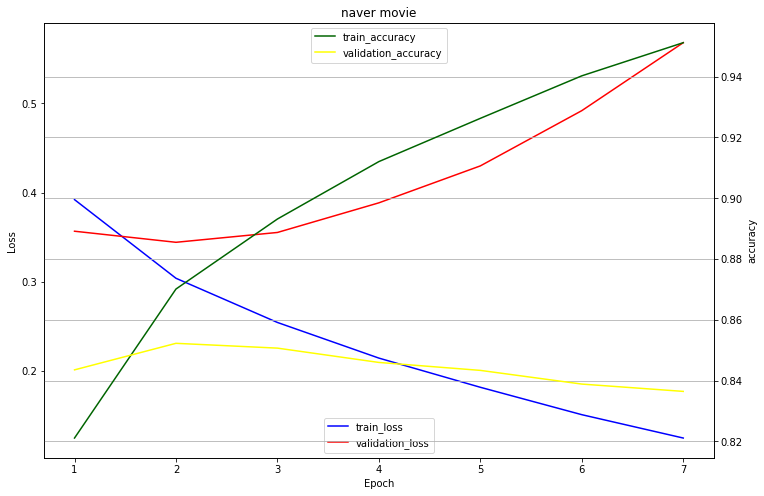

In [57]:
import matplotlib.pyplot as plt
#X축은 공유
#y축의 좌측=loss, 우측=accuracy
fig,ax0=plt.subplots(figsize=(12,8))#평소랑 다름.
ax1=ax0.twinx() 

ax0.plot(xs,y_loss,label='train_loss',c='blue')
ax0.plot(xs,y_vloss,label='validation_loss',c='red')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')
ax0.legend(loc='lower center');

ax1.plot(xs,y_acc,label='train_accuracy',c='darkgreen')
ax1.plot(xs,y_vacc,label='validation_accuracy',c='yellow')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper center');

plt.title('naver movie')
plt.grid();

plt.show()

## 8. conv 1d + GRU 써보기

In [58]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalMaxPooling1D,GRU,Dropout


from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical



In [59]:
model2=Sequential ([Embedding(num_words,120,input_length=max_len),
                    Dropout(0.5),
                    Conv1D(64,5,activation='relu'),
                    MaxPooling1D(5),
                    GRU(128),
                    Dense(1,activation='sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 120)           2400000   
                                                                 
 dropout (Dropout)           (None, 40, 120)           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 64)            38464     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                      

In [62]:
model2.compile('adam','binary_crossentropy',['accuracy'])
model2_path='best-navermovie-conv1d-gru.h5'
mc2=ModelCheckpoint(model2_path,verbose=1,save_best_only=True)
es2=EarlyStopping(patience=2)
hist2=model2.fit(
    X_train,y_train,validation_split=0.2,
    epochs=30,batch_size=128,callbacks=[mc2,es2]
)
best_model2=load_model(model2_path)
best_model2.evaluate(X_test,y_test)

Epoch 1/30
904/909 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.8918
Epoch 1: val_loss improved from inf to 0.45294, saving model to best-navermovie-conv1d-gru.h5
909/909 [==============================] - 9s 7ms/step - loss: 0.2453 - accuracy: 0.8918 - val_loss: 0.4529 - val_accuracy: 0.8049
Epoch 2/30
907/909 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9031
Epoch 2: val_loss did not improve from 0.45294
909/909 [==============================] - 5s 6ms/step - loss: 0.2225 - accuracy: 0.9031 - val_loss: 0.4945 - val_accuracy: 0.8026
Epoch 3/30
900/909 [============================>.] - ETA: 0s - loss: 0.2022 - accuracy: 0.9111
Epoch 3: val_loss did not improve from 0.45294
1527/1527 [==============================] - 4s 2ms/step - loss: 0.4586 - accuracy: 0.8017


[0.45855551958084106, 0.801686704158783]